In [1]:
import os
import re
import tables as tb
import brian2 as br
import matplotlib as mpl
import matplotlib.pyplot as plt

from brian2 import numpy as np
from brian2 import um, mm, cm, meter
from brian2 import mV, ms, second, ohm, siemens, msiemens, farad, ufarad

import pyoelectricity as pel

In [2]:
datapath = 'simulation/end-end/'

# Load files

In [11]:
all_files = sorted(os.listdir(datapath), reverse=True)
result_filenames = [f for f in all_files if re.search(r'2k.*.h5', f)]

# list all files
#for i, filename in enumerate(result_filenames):
#    morpho = filename.split('.')[-2][-2:]
#    model = filename.split('.')[-2].split('spine-')[-1][:-2]
#    print(f'{i:2d}: {filename:35s} {model:6s} {morpho:3s}')

# Load files
e_result_filenames = [f for f in result_filenames if re.search(r'ee-.*2k.*(ss|bb).h5', f)]
e_results ={}
for e in (e_result_filenames):
    print('Loading ', e)
    e_results[e] = pel.get_result(datapath+e)

Loading  ee-2k-.1us-.3mmspine-tm450ss.h5
Loading  ee-2k-.1us-.3mmspine-tm450bb.h5
Loading  ee-2k-.1us-.3mmspine-tm1200ss.h5
Loading  ee-2k-.1us-.3mmspine-tm1200bb.h5
Loading  ee-2k-.1us-.3mmspine-hhss.h5
Loading  ee-2k-.1us-.3mmspine-hhbb.h5


# Morphology - compartment positions

ee-2k-.1us-.3mmspine-tm450ss.h5 (2000, 60020)
ee-2k-.1us-.3mmspine-tm450bb.h5 (2000, 60020)


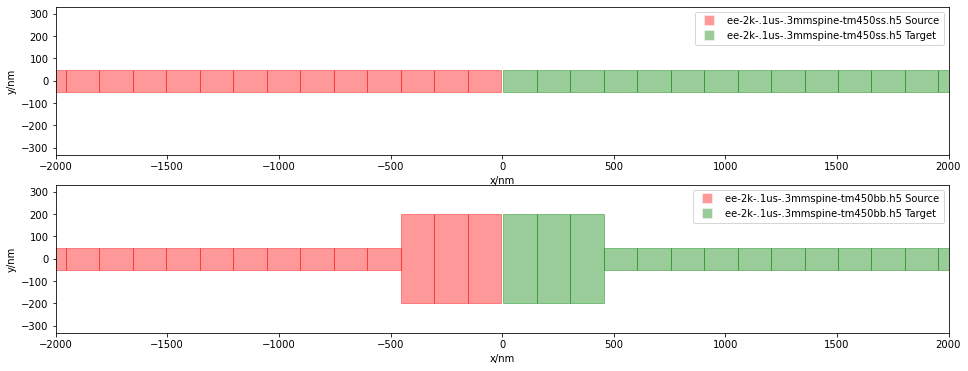

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16,6))

nm = br.nmeter

for result_file, ax in zip(e_result_filenames[:2], axs):
    result = e_results[result_file]
    print(result_file, result['source_v'].shape)
    
    source_patchs = []
    dx = (result['source_x'][1]-result['source_x'][0])/nm
    x0 = (result['source_x'][-1] + result['target_x'][0])/2/nm
    for x, y, d in zip(result['source_x']/nm -x0,
                       result['source_y']/nm,
                       result['source_d']/nm):
        x_off = dx/2
        y_off = d/2
        source_patchs.append(plt.Rectangle((x-x_off, y-y_off), dx, d) )
    ax.add_collection(mpl.collections.PatchCollection(source_patchs, color='red', alpha=0.4, label="Source"))    
    
    target_patchs = []
    dx = (result['target_x'][1]-result['target_x'][0])/nm
    for x, y, d in zip(result['target_x']/nm -x0,
                       result['target_y']/nm,
                       result['target_d']/nm):
        x_off = dx/2
        y_off = d/2
        target_patchs.append(plt.Rectangle((x-x_off, y-y_off), dx, d) )
    ax.add_collection(mpl.collections.PatchCollection(target_patchs, color='green', alpha=0.4, label="Target"))    

    ax.axis('equal')
    #ax.set_xlim(result['source_x'][-1]/nm - 2 , result['target_x'][1]/nm +2)
    ax.set_xlim(-2000 , 2000)
    ax.set_ylim(-300, 300)
    ax.set_xlabel('x/nm')
    ax.set_ylabel('y/nm')
    legend_elements = [mpl.lines.Line2D([0], [0], marker='s', color='w',
                                        markerfacecolor='red', markersize=10,
                                        alpha=0.4, label=result_file+' Source'),
                       mpl.lines.Line2D([0], [0], marker='s', color='w',
                                        markerfacecolor='green', markersize=10,
                                        alpha=0.4, label=result_file+' Target')]
    ax.legend(handles=legend_elements)

plt.show()

# Overview
## External potential at target tip

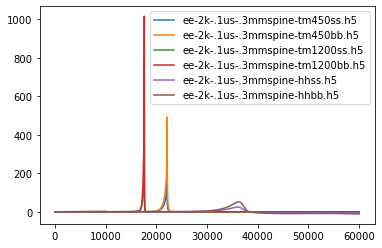

In [8]:
for rfn in e_result_filenames:
    result = e_results[rfn]
    plt.plot(result['v_ext_v'][0]/br.uvolt, label = rfn)
plt.legend();

 ## Target membrane potential (SI Figure)

  499 = 74.9 um |  37123 = 3.7 ms |  1.0 uV | >-<  0.16 um
  178 = 26.7 um |  36476 = 3.6 ms |  1.9 uV | >-<  0.16 um
   79 = 11.8 um |  22108 = 2.2 ms |  4.1 uV | >-<  0.16 um
   23 =  3.5 um |  22139 = 2.2 ms | 28.3 uV | >-<  0.16 um


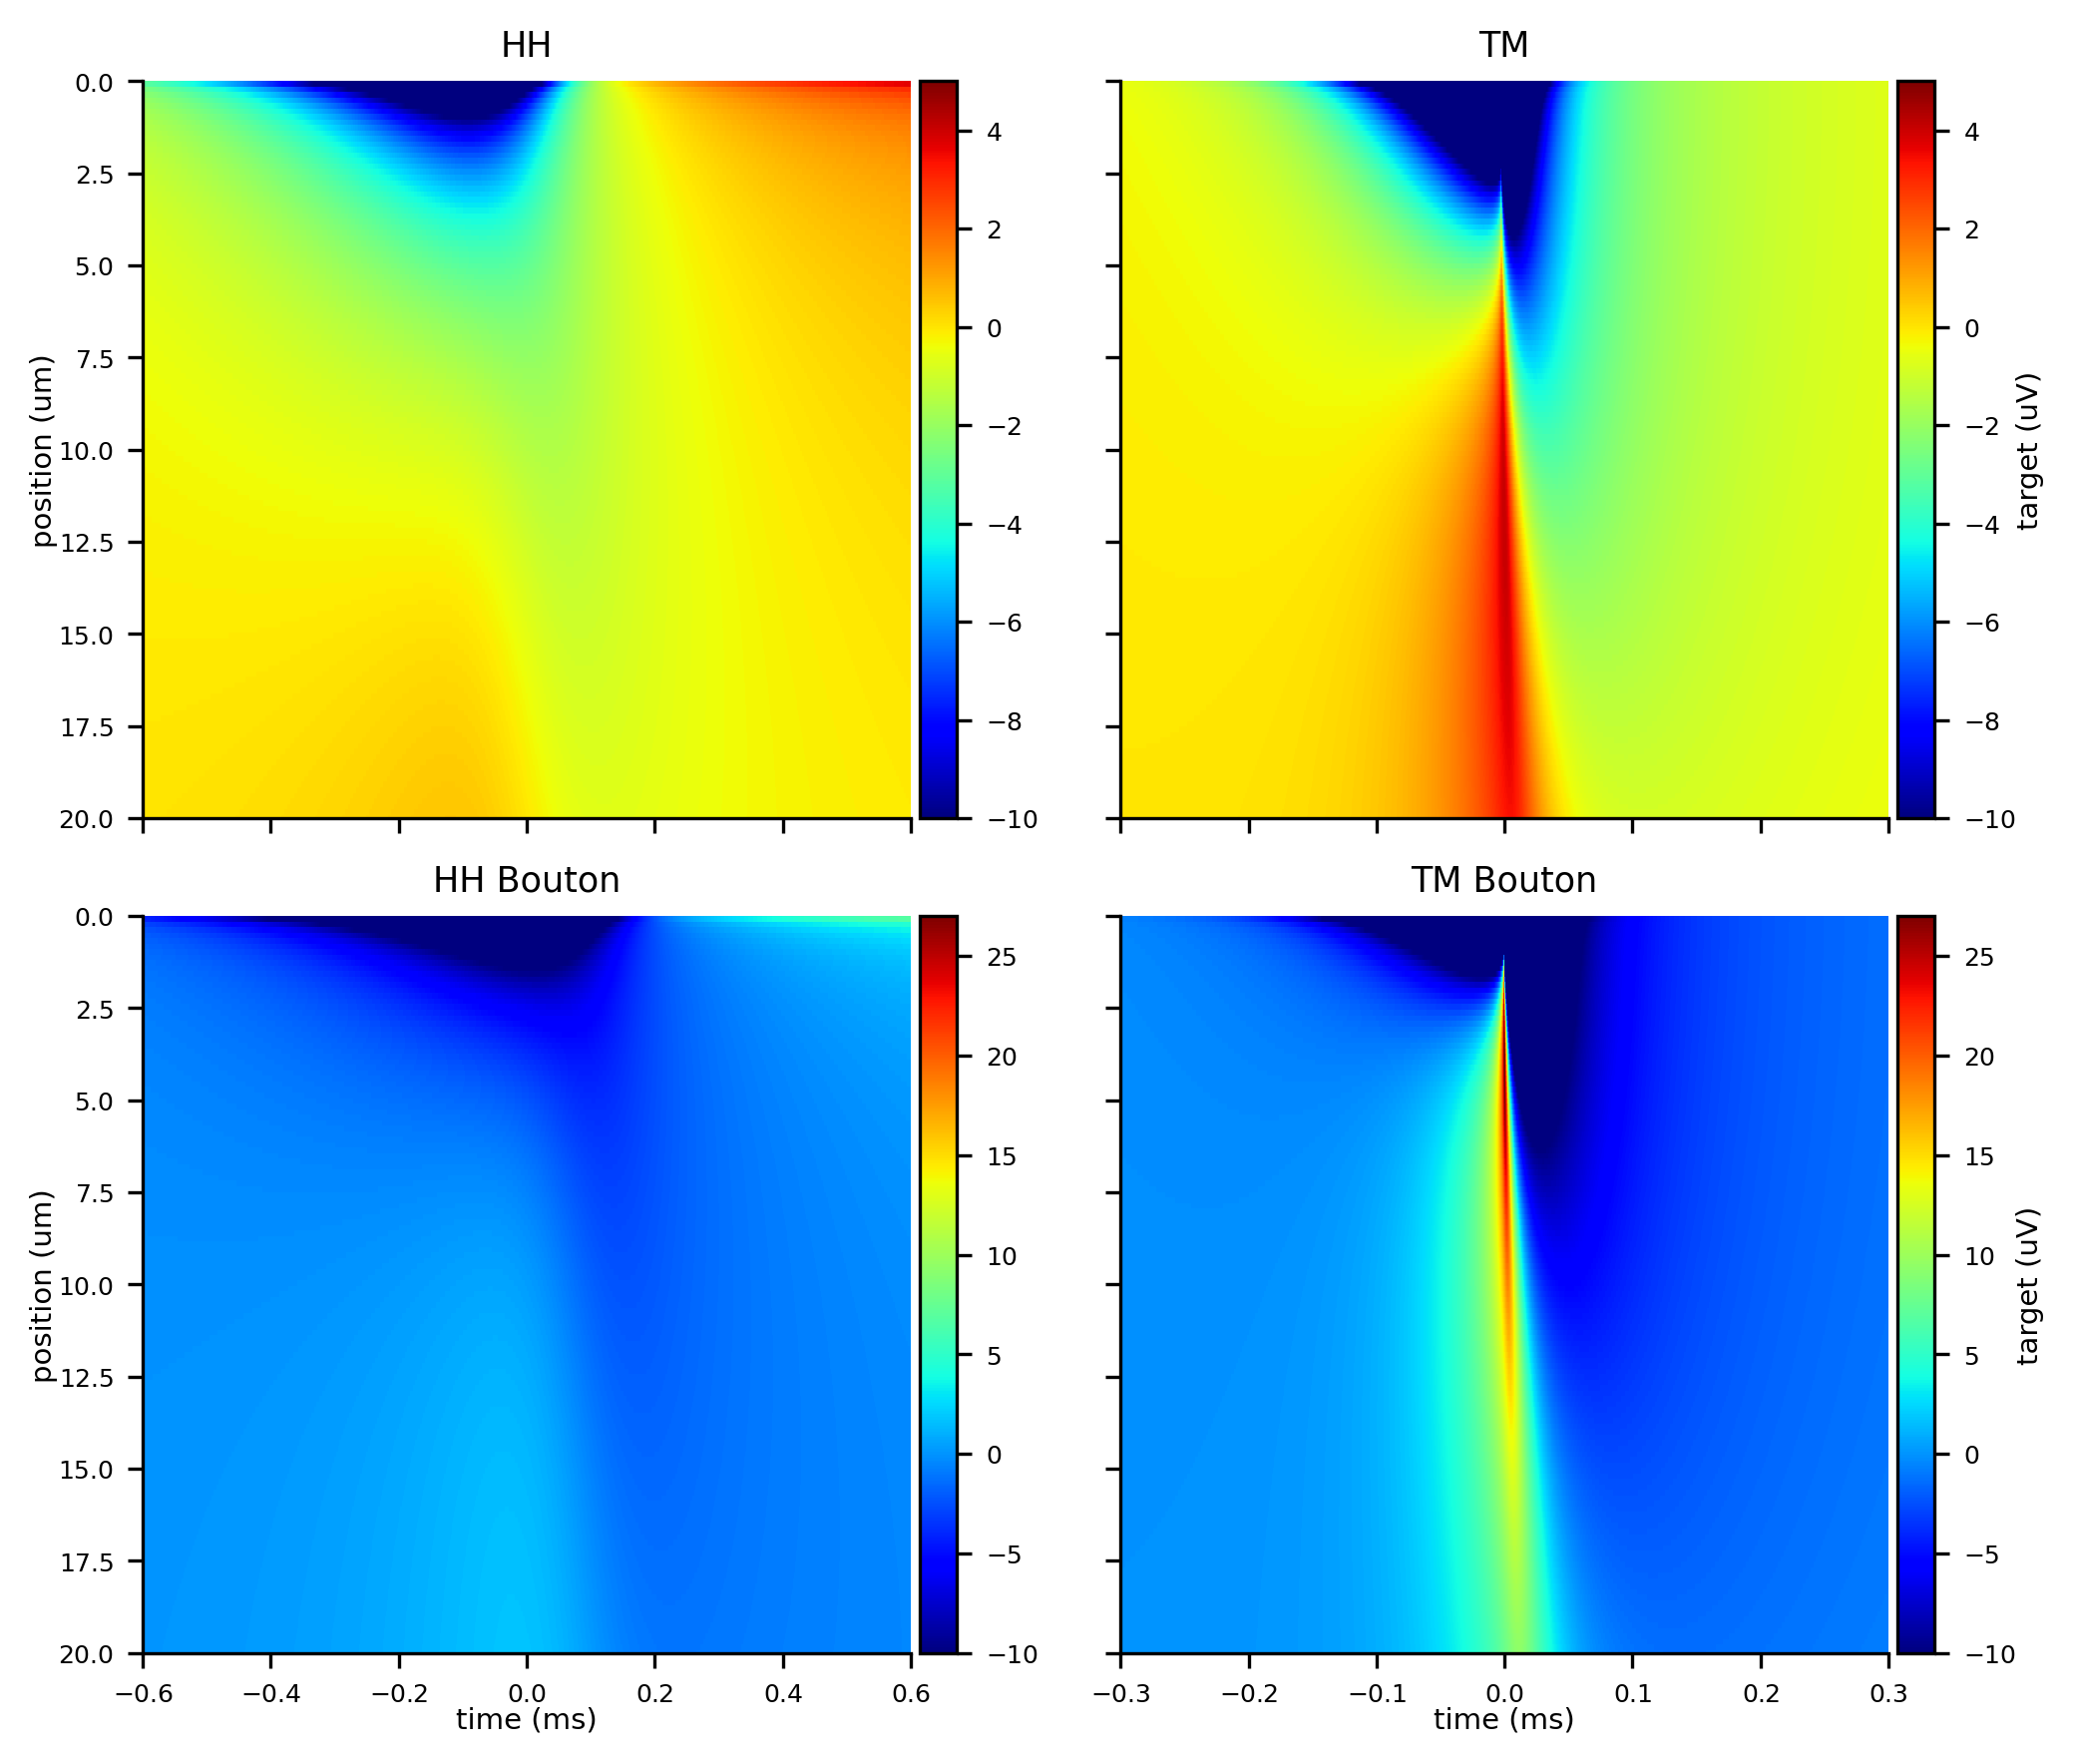

In [9]:
def find_dist_depol(result):
    #x_coff = (result['target_x'] - result['target_x'][0]) - 
    v2 = result['target_v'][:,result['target_t']<(3.8*ms)]
    ix, it = np.unravel_index(np.argmax(v2, axis=None), v2.shape)
    x_um = (result['target_x'][ix] - result['target_x'][0])/br.um
    t_ms = (result['target_t'][it])/br.ms
    vmax_uv = v2.max()/br.uvolt
    comp_dist = result['target_x'][0] - result['source_x'][-1]

    print(f"{ix:5d} = {x_um:4.1f} um | {it:6d} ={t_ms:4.2} ms | {vmax_uv:4.1f} uV | >-< {comp_dist/br.um:5.3} um")
    return ix, it

def putimg(title, result, ax, dt=0.6, clbl='target (uV)', **kwargs):
    ax.set_title(title)
    ix, it = find_dist_depol(result)
    t0 = result['target_t'][it]/br.ms
    x0 = result['target_x'][0]/br.um
    
    im0 = ax.imshow(result['target_v']/br.uvolt,
                    extent=[(result['target_t'][0])/br.ms -t0,
                            (result['target_t'][-1])/br.ms -t0,
                            (result['target_x'][-1])/br.um -x0,
                            (result['target_x'][0])/br.um -x0,
                           ],
                    aspect='auto',
                    interpolation='none',
                    vmin=-10,
                    cmap='jet',#'nipy_spectral',
                    **kwargs
                   )
    
    #ax.axhline(result['target_x'][ix]/br.um - x0, ls = '--')
    #ax.axvline(result['target_t'][it]/br.ms - t0, ls = '--')
    ax.set_xlim(-dt, +dt)
    ax.set_ylim(20, 0)
    
    fig.colorbar(im0, ax=ax, pad=0.01, label=clbl)


with plt.style.context('plot_style.txt'):
    cm = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(2,2, figsize=(17.8*cm,15*cm), sharey=True, sharex='col')
    
    putimg(result=e_results['ee-2k-.1us-.3mmspine-hhss.h5'],
           ax=axs[0,0],
           title='HH',
           clbl='',
           vmax=5)
    putimg(result=e_results["ee-2k-.1us-.3mmspine-hhbb.h5"],
           ax=axs[1,0],
           title='HH Bouton',
           clbl='',
          vmax=27)
    putimg(result=e_results["ee-2k-.1us-.3mmspine-tm450ss.h5"],
           ax=axs[0,1],
           title='TM',
           dt=0.3,
          vmax=5)
    putimg(result=e_results["ee-2k-.1us-.3mmspine-tm450bb.h5"],
           ax=axs[1,1],
           title='TM Bouton',
           dt=0.3,
          vmax=27)

    axs[0,0].set_ylabel('position (um)')
    axs[1,0].set_ylabel('position (um)')

    axs[1,0].set_xlabel('time (ms)')
    axs[1,1].set_xlabel('time (ms)')
    fig.tight_layout()
    plt.savefig("SI-spine.pdf")

# Figure 4 end-end

hh         i_x:79 pos_x:11.85 um   t0:3.77 ms
hh         i_x:23 pos_x:3.45 um    t0:3.72 ms
tm450      i_x:79 pos_x:11.85 um   t0:2.26 ms
tm450      i_x:23 pos_x:3.45 um    t0:2.23 ms


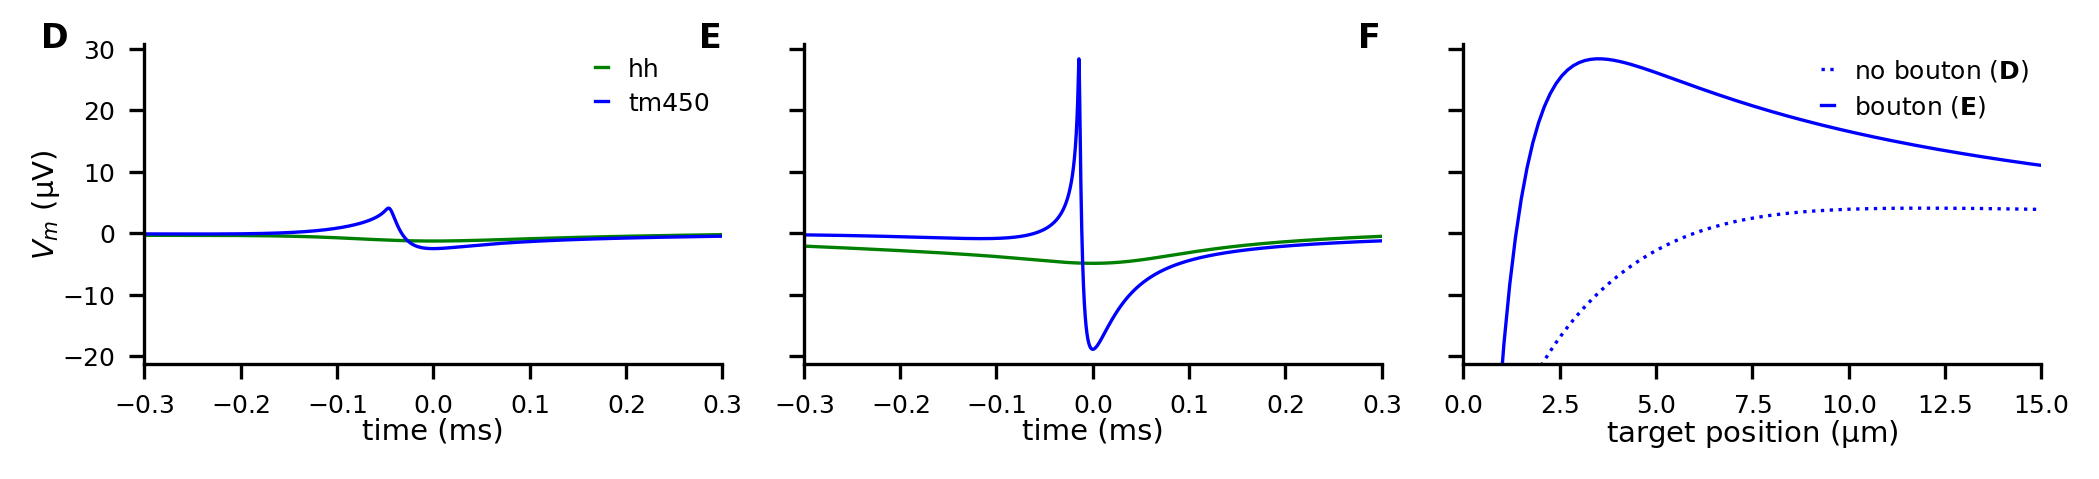

In [10]:
with plt.style.context('plot_style.txt'):
    cm = 1/2.54 # 11.4 or 17.8
    fig, axs = plt.subplots(1, 3, sharey=True, figsize=(17.8*cm,4*cm))
    
    def mk_ee_plt(result, model, ax, ix=None, **kwargs):
        v, t = result['target_v'], result['target_t']
        
        #ix = np.abs(result['target_x']-(result['target_x'][0]+5*um)).argmin()
        if ix is None:
            v2 = v[:,result['target_t']<(4*ms)]
            ix, it = np.unravel_index(np.argmax(v2, axis=None), v2.shape)
            t_0 = t[it]
        else:
            v2 = v[ix,:]
            it = v2.argmin()
            t_0 = t[it]

        print(f"{model:10s} i_x:{ix} pos_x:{(result['target_x'][ix] - result['target_x'][0]).in_best_unit(5):10}"
              +f" t0:{t_0.in_best_unit(2)}")
        
        ax.plot((t-t_0)/ms, v[ix, :]/br.uvolt, label=model, **kwargs)
        return result
            
    r_sshh = mk_ee_plt(
        model='hh',
        ix=79,
        result=e_results['ee-2k-.1us-.3mmspine-hhss.h5'],
        ax=axs[0], color = 'green')
    r_bbhh = mk_ee_plt(
        model="hh",
        ix=23,
        result=e_results["ee-2k-.1us-.3mmspine-hhbb.h5"],
        ax=axs[1], color = 'green')
    r_sstm = mk_ee_plt(
        model="tm450",
        ix=79,
        result=e_results["ee-2k-.1us-.3mmspine-tm450ss.h5"],
        ax=axs[0], color = 'blue')
    r_bbtm = mk_ee_plt(
        model="tm450",
        ix=23,
        result=e_results["ee-2k-.1us-.3mmspine-tm450bb.h5"],
        ax=axs[1], color = 'blue')
    
    axs[0].set_ylabel("$V_m$ ($\mathrm{\mu}$V)")
    axs[0].legend()
    axs[0].set_xlim(-0.3, 0.3)
    axs[1].set_xlim(-0.3, 0.3)
    axs[0].set_xlabel("time (ms)")
    axs[1].set_xlabel("time (ms)")
    saved_ylims = axs[0].get_ylim()
    
    def mk_profile_plt(result, **kwargs):
        v = result['target_v']/br.uvolt
        v2 = v[:,result['target_t']<(4*ms)]
        i_x, i_t = np.unravel_index(np.argmax(v2, axis=None), v2.shape)
        #x0, t0 = result['target_x'][i_x], result['target_t'][i_t]
        xs = (result['target_x'] - result['target_x'].min())/br.um
        axs[2].plot(xs, v[:,i_t], **kwargs)
        #axs[2].plot(xs, v2.max(1), alpha=0.5, **kwargs)
        
    mk_profile_plt(result=r_sstm, color='blue', ls=':', label = 'no bouton ($\mathbf{D}$)')
    mk_profile_plt(result=r_bbtm, color='blue', label = 'bouton ($\mathbf{E}$)')
    #mk_profile_plt(result=r_sshh, color='green', ls=':', label = 'HH straight ($\mathbf{D}$)')
    #mk_profile_plt(result=r_bbhh, color='green', label = 'HH bouton ($\mathbf{E}$)')
    
    axs[2].set_ylim(saved_ylims)
    axs[2].set_xlim(0,15)
    axs[2].legend()
    axs[2].set_xlabel("target position ($\\mathrm{\mu m}$)")
    
    plt.tight_layout()
    for ax, l in zip(axs, ['D', 'E', 'F']):
        #ax.grid()
        X = ax.get_position().x0 - 0.05
        Y = 0.90
        ax.annotate(l, fontsize=8,family = 'sans-serif', weight = 'bold',
                    xycoords="subfigure fraction",  xy=(X, Y)) 
        
    fig.savefig('Fig4-DEF3.svg', bbox_inches='tight')
    
    plt.show()